## GPU Info

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Aug 28 16:50:40 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P0    28W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## RAM

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


## Mounting Google Drive

In [3]:
#Mounting Google Drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Installing Dependencies

In [4]:
!pip3 install transformers datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 4.9 MB/s 
     |████████████████████████████████| 365 kB 75.1 MB/s 
     |████████████████████████████████| 120 kB 77.2 MB/s 
     |████████████████████████████████| 6.6 MB 68.5 MB/s 
     |████████████████████████████████| 212 kB 61.6 MB/s 
     |████████████████████████████████| 115 kB 81.2 MB/s 
     |████████████████████████████████| 127 kB 87.1 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [4]:
from transformers import AutoTokenizer, AutoConfig, AutoModel, AutoModelForSequenceClassification, pipeline, DataCollatorWithPadding
from datasets import load_dataset, Dataset, Value, ClassLabel, Features
import os
import re
import random
import numpy as np
import pandas as pd
import time
import torch
from tqdm import tqdm as tqdm

pd.options.display.max_rows = 4000

#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print("Imports Done")

Imports Done


## Hyperparameters

In [5]:
#defaults
train_batch_size = 32
num_epochs = 10
warmup_steps = 500
weight_decay = 0.01
random_state = 42

evaluation_steps = 10000
confidence_threshold = 0.30
checkpoint = "roberta-base"
transformer_model = "roberta-base"
model_save_path = f'/content/drive/MyDrive/NLP/Transformers/Irony Detection/models/{transformer_model}_{num_epochs}_{train_batch_size}'

print(model_save_path)

/content/drive/MyDrive/NLP/Transformers/Irony Detection/models/roberta-base_10_32


## Data Pre-Processing

In [7]:
#downloading the Tweet_Eval Dataset from HuggingFace Hub

from datasets import load_dataset
raw_datasets = load_dataset("tweet_eval", "irony")
raw_datasets

Extracting data files:   0%|          | 0/6 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/2862 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/784 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/955 [00:00<?, ? examples/s]

Dataset tweet_eval downloaded and prepared to /root/.cache/huggingface/datasets/tweet_eval/irony/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 2862
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 784
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 955
    })
})

In [8]:
raw_datasets["train"][0]

{'text': 'seeing ppl walking w/ crutches makes me really excited for the next 3 weeks of my life',
 'label': 1}

In [9]:
#Storing the dataset to Drive to check for class imbalance

train_data = pd.DataFrame(columns = ["Phrase", "labels"])

phrases = []
labels = []

for idx in range(len(raw_datasets["train"])):
  phrases.append(raw_datasets["train"][idx]["text"])
  labels.append(raw_datasets["train"][idx]["label"])

train_data["Phrase"] = phrases
train_data["labels"] = labels

train_data

,Phrase,labels
0,seeing ppl walking w/ crutches makes me really...,1
1,"look for the girl with the broken smile, ask h...",0
2,Now I remember why I buy books online @user #s...,1
3,@user @user So is he banded from wearing the c...,1
4,Just found out there are Etch A Sketch apps. ...,1
5,"Hey what do you know, one of the witnesses sup...",1
6,@user on stage at #flzjingleball at the @user ...,0
7,You know it's going to be a great day when you...,1
8,Halfway thorough my workday ... Woooo,1
9,Would like to thank my nephew for giving me hi...,1


In [10]:
train_data.labels.value_counts()

1    1445
0    1417
Name: labels, dtype: int64

We clearly don't have class imbalance here, which means we can proceed with our fine tuning. Amazing !

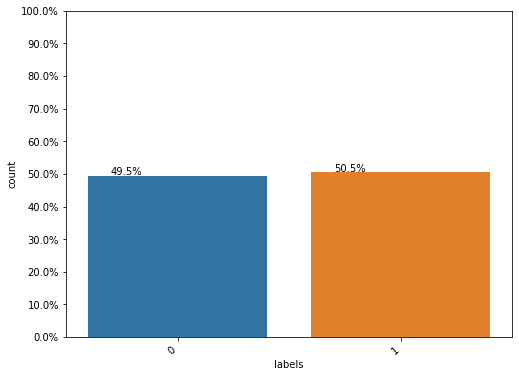

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
Y = train_data["labels"]
total = len(Y)*1.
ax=sns.countplot(x="labels", data=train_data)

for p in ax.patches:
    ax.annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x()+0.1, p.get_height()+5))

ax.yaxis.set_ticks(np.linspace(0, total, 11))
ax.set_yticklabels(map('{:.1f}%'.format, 100*ax.yaxis.get_majorticklocs()/total))
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.show()

In [12]:
validation_data = pd.DataFrame(columns = ["Phrase", "labels"])

phrases = []
labels = []

for idx in range(len(raw_datasets["validation"])):
  phrases.append(raw_datasets["validation"][idx]["text"])
  labels.append(raw_datasets["validation"][idx]["label"])

validation_data["Phrase"] = phrases
validation_data["labels"] = labels

validation_data

,Phrase,labels
0,#NBA players #NY support protests of #police k...,1
1,A new year about to start|So many people came ...,0
2,"Obama's $1,176,120.90 in Taxpayer Funded Costs...",1
3,Can't wait to work with the dream team again t...,1
4,!!! RT @user Of all the places to get stuck in...,1
5,@user THX4FLW! FLWtheMUSIC @user @user WE R #E...,0
6,#40 #Corner #Cute #Day #Expensive #diy #crafts...,0
7,#notcies #eu EU backs 328 top early-career res...,0
8,@user I think it's a safe bet it won't fit the...,0
9,@user oh haha no they ain't 😂😂 you ain't even ...,0


In [13]:
test_data = pd.DataFrame(columns = ["Phrase", "labels"])

phrases = []
labels = []

for idx in range(len(raw_datasets["test"])):
  phrases.append(raw_datasets["test"][idx]["text"])
  labels.append(raw_datasets["test"][idx]["label"])

test_data["Phrase"] = phrases
test_data["labels"] = labels

test_data

,Phrase,labels
0,@user Can U Help?||More conservatives needed o...,0
1,"Just walked in to #Starbucks and asked for a ""...",1
2,#NOT GONNA WIN,0
3,@user He is exactly that sort of person. Weirdo!,0
4,So much #sarcasm at work mate 10/10 #boring 10...,1
5,Corny jokes are my absolute favorite,0
6,People complain about my backround pic and all...,1
7,"@user @user Darn, my sock joke needs fixing?",0
8,if Christian expects Fifa to sleep in my bed w...,0
9,"People who tell people with anxiety to ""just s...",1


In [14]:
train_data = train_data.replace(to_replace = [0, 1], value = ["not_irony", "irony"])
validation_data = validation_data.replace(to_replace = [0, 1], value = ["not_irony", "irony"])
test_data = test_data.replace(to_replace = [0, 1], value = ["not_irony", "irony"])

In [15]:
train_data.iloc[0]

Phrase    seeing ppl walking w/ crutches makes me really...
labels                                                irony
Name: 0, dtype: object

In [16]:
#Storing all these datasets onto my Drive
train_data.to_csv("/content/drive/MyDrive/NLP/Transformers/Irony Detection/train_data.csv", index = False)
validation_data.to_csv("/content/drive/MyDrive/NLP/Transformers/Irony Detection/validation_data.csv", index = False)
test_data.to_csv("/content/drive/MyDrive/NLP/Transformers/Irony Detection/test_data.csv", index = False)

In [6]:
filepath_train = "/content/drive/MyDrive/NLP/Transformers/Irony Detection/train_data.csv"
filepath_validation = "/content/drive/MyDrive/NLP/Transformers/Irony Detection/validation_data.csv"
filepath_test = "/content/drive/MyDrive/NLP/Transformers/Irony Detection/test_data.csv"

## Loading onto HF Datasets

In [7]:
data_files = {"train": filepath_train, "validation": filepath_validation}
ClassLabels = ClassLabel(num_classes=2, names = ["not_irony", "irony"])
features = Features({"Phrase": Value("string"), "labels": ClassLabels})
raw_dataset = load_dataset("csv", data_files=data_files, features = features)
raw_dataset

  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['Phrase', 'labels'],
        num_rows: 2862
    })
    validation: Dataset({
        features: ['Phrase', 'labels'],
        num_rows: 955
    })
})

In [8]:
raw_dataset["validation"][0]

{'Phrase': '#NBA players #NY support protests of #police killings/sure #money donations for #college WB coming',
 'labels': 1}

In [9]:
raw_dataset["train"].features

{'Phrase': Value(dtype='string', id=None),
 'labels': ClassLabel(num_classes=2, names=['not_irony', 'irony'], id=None)}

## Defining Model

In [10]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels = 2)

model.config

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.2",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

## Defining Tokenizer

In [11]:
#from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoConfig, DataCollatorWithPadding

tokenizer = AutoTokenizer.from_pretrained(checkpoint)

print("Done !")

Done !


## Batchwise Tokenization

In [12]:
def tokenize_function(example):
    #return tokenizer(example["Phrase"])
    return tokenizer(example["Phrase"], padding = True)

tokenized_dataset = raw_dataset.map(tokenize_function, batched = True, remove_columns = "Phrase")
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

print("Done")

  0%|          | 0/1 [00:00<?, ?ba/s]

Done


In [13]:
tokenized_dataset["train"][0]

{'labels': 1,
 'input_ids': [0,
  33471,
  181,
  2911,
  3051,
  885,
  73,
  3977,
  1182,
  5559,
  817,
  162,
  269,
  2283,
  13,
  5,
  220,
  155,
  688,
  9,
  127,
  301,
  2,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0]}

In [14]:
#Checking tokenization results
tokenizer.convert_ids_to_tokens(tokenized_dataset["train"][20]["input_ids"])

['<s>',
 'Need',
 'Ġto',
 'Ġget',
 'Ġback',
 'Ġin',
 'Ġto',
 'Ġcollege',
 '..',
 'Ġ',
 'Ġ#',
 'fe',
 'eling',
 'Ġ#',
 'this',
 '</s>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>']

In [34]:
#Deciding how many tokens to pad up to & truncate down to!

lengths = []
for idx in range(len(tokenized_dataset["train"])):
  lengths.append(len(tokenized_dataset["train"][idx]["input_ids"]))
print("Done")

Done


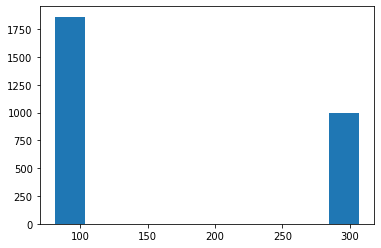

In [35]:
import matplotlib.pyplot as plt
plt.hist(lengths)
plt.show()

In [36]:
max(lengths)

307

Without truncation & padding, we see that the input sequences need not really be truncated, since roberta-base has a max input sequence length of 512 & the maximum sequence length here is 307. All we need to do is pad up to the length of the longest sequence in every batch. Easy enough !

In [15]:
#setting the dataset format to torch to be compatible with PyTorch

tokenized_dataset.set_format(type = "torch")

## Fine Tuning

In [16]:
from transformers import TrainingArguments

training_args = TrainingArguments("test-trainer", 
                                  num_train_epochs = num_epochs,
                                  warmup_steps = warmup_steps,
                                  weight_decay = weight_decay,
                                  per_device_train_batch_size = train_batch_size,
                                  per_device_eval_batch_size = train_batch_size,
                                  evaluation_strategy = "epoch",
                                  save_strategy = "epoch",
                                  logging_strategy = "epoch",
                                  load_best_model_at_end = True)

print("Done !")

Done !


In [17]:
from transformers import Trainer

trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
)

print("Done !")

Done !


In [18]:
#Trainer API is configured to automatically shift everything to GPU if available !

trainer.args.device

device(type='cuda', index=0)

In [19]:
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 2862
  Num Epochs = 10
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 900


Epoch,Training Loss,Validation Loss
1,0.691600,0.673819
2,0.621800,0.611911
3,0.510800,0.516174
4,0.384700,0.574607
5,0.273900,0.644613
6,0.162300,0.846262
7,0.119000,0.869178
8,0.079700,1.131574
9,0.035800,1.512345
10,0.013600,1.570661


***** Running Evaluation *****
  Num examples = 955
  Batch size = 32
Saving model checkpoint to test-trainer/checkpoint-90
Configuration saved in test-trainer/checkpoint-90/config.json
Model weights saved in test-trainer/checkpoint-90/pytorch_model.bin
tokenizer config file saved in test-trainer/checkpoint-90/tokenizer_config.json
Special tokens file saved in test-trainer/checkpoint-90/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 955
  Batch size = 32
Saving model checkpoint to test-trainer/checkpoint-180
Configuration saved in test-trainer/checkpoint-180/config.json
Model weights saved in test-trainer/checkpoint-180/pytorch_model.bin
tokenizer config file saved in test-trainer/checkpoint-180/tokenizer_config.json
Special tokens file saved in test-trainer/checkpoint-180/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 955
  Batch size = 32
Saving model checkpoint to test-trainer/checkpoint-270
Configuration saved in test-trainer/checkp

TrainOutput(global_step=900, training_loss=0.2893173474735684, metrics={'train_runtime': 1580.4965, 'train_samples_per_second': 18.108, 'train_steps_per_second': 0.569, 'total_flos': 4515201543265200.0, 'train_loss': 0.2893173474735684, 'epoch': 10.0})

## Saving Fine Tuned Model

In [20]:
trainer.save_model(model_save_path)

Saving model checkpoint to /content/drive/MyDrive/NLP/Transformers/Irony Detection/models/roberta-base_10_32
Configuration saved in /content/drive/MyDrive/NLP/Transformers/Irony Detection/models/roberta-base_10_32/config.json
Model weights saved in /content/drive/MyDrive/NLP/Transformers/Irony Detection/models/roberta-base_10_32/pytorch_model.bin
tokenizer config file saved in /content/drive/MyDrive/NLP/Transformers/Irony Detection/models/roberta-base_10_32/tokenizer_config.json
Special tokens file saved in /content/drive/MyDrive/NLP/Transformers/Irony Detection/models/roberta-base_10_32/special_tokens_map.json


## Loading Data Batchwise For Inference to avoid RAM Overflow

In [21]:
import math
batch_len = 50
test_dataset = pd.read_csv(filepath_test)
num_batches = math.ceil(len(test_dataset)/batch_len)
data_loader = []
s_idx = 0
e_idx = batch_len
for _ in range(num_batches):
  data_loader.append(test_dataset.Phrase.to_list()[s_idx:(e_idx if e_idx <= len(test_dataset) else len(test_dataset))])
  s_idx += batch_len
  e_idx += batch_len

In [22]:
data_loader[-1]

['Laborers in the San Joaquin Valley, one of the most productive farming regions in the world, suffer from food insecurity. #irony #poverty',
 "I think my friend just sent @user a snapchat of me drinkin water, cuz she's fun like that #sarcasm #rehydratewhenyadehydrate #brat",
 "Girls won't answer their phone when I'm calling them bc they think I'm calling them in early but I'm actually calling to cut them #irony",
 "@user make sure you don't say Christmas!! The decorate for the holiday. #sarcasm #itisachristmastree",
 'Re: prison book ban - Of course Grayling is also trying to ban Judicial Reviews #irony',
 'Rolled out of bed for closing.... #ilookreallygood #not',
 'Watching VT and Cincy - qb for VT with (GODS) down left arm (GIFT) down right arm. - #irony #howmanygods #punctuationmatters',
 'you seem super smart MT "@GrannyMarried: @user @user ||#NO #BLEEDING happening in #WaterBoarding = it\'s #Not #Torture"',
 '@user Cheers bro! Top man 🙋',
 'Even getting cooked breakfast.. Hes def

## Inference

In [23]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_save_path)
model = AutoModelForSequenceClassification.from_pretrained(model_save_path)

lst_tensors = []

start_time = time.time()

for idx in tqdm(range(num_batches)):
  #Following the same truncation & padding strategy we used while training
  encoded_input = tokenizer(data_loader[idx], padding = True, return_tensors='pt')
  output = model(**encoded_input)["logits"]
  #avoiding RAM Overflow
  del encoded_input
  lst_tensors.append(output.detach())
  #avoiding RAM overflow
  del output

print(f"Inference using {checkpoint} on {len(test_dataset)} phrases takes {time.time() - start_time} seconds")

print("Done !")

Didn't find file /content/drive/MyDrive/NLP/Transformers/Irony Detection/models/roberta-base_10_32/added_tokens.json. We won't load it.
loading file /content/drive/MyDrive/NLP/Transformers/Irony Detection/models/roberta-base_10_32/vocab.json
loading file /content/drive/MyDrive/NLP/Transformers/Irony Detection/models/roberta-base_10_32/merges.txt
loading file /content/drive/MyDrive/NLP/Transformers/Irony Detection/models/roberta-base_10_32/tokenizer.json
loading file None
loading file /content/drive/MyDrive/NLP/Transformers/Irony Detection/models/roberta-base_10_32/special_tokens_map.json
loading file /content/drive/MyDrive/NLP/Transformers/Irony Detection/models/roberta-base_10_32/tokenizer_config.json
loading configuration file /content/drive/MyDrive/NLP/Transformers/Irony Detection/models/roberta-base_10_32/config.json
Model config RobertaConfig {
  "_name_or_path": "/content/drive/MyDrive/NLP/Transformers/Irony Detection/models/roberta-base_10_32",
  "architectures": [
    "RobertaF

Inference using roberta-base on 784 phrases takes 52.63657355308533 seconds
Done !


In [24]:
import torch
#concatenating all logits tensors
outputs = torch.cat(lst_tensors, 0)
outputs

tensor([[ 0.8461, -1.0242],
        [-0.5652,  0.6777],
        [ 1.0028, -1.2535],
        ...,
        [-0.1937,  0.3534],
        [-0.8970,  1.0588],
        [ 1.3827, -1.6656]])

In [25]:
#We're adding in a softmax to convert logits into prediciton probabilities here

import torch.nn as nn
softmax = nn.Softmax(dim = 1)
#prediction_probabilities = list(softmax(output["logits"]).detach().numpy())
prediction_probabilities = list(softmax(outputs).detach().numpy())
predictions = []
for x,y in prediction_probabilities:
    predictions.append(0) if x > y else predictions.append(1)
print("Done !")

Done !


In [26]:
ground_truths = test_dataset.labels.to_list()
ground_truths = [1 if ele == "irony" else 0 for ele in ground_truths]

## Classification Report

In [27]:
from sklearn.metrics import classification_report

print(classification_report(ground_truths, predictions, target_names = ["Not Irony (0)", "Irony (1)"]))

               precision    recall  f1-score   support

Not Irony (0)       0.73      0.78      0.75       473
    Irony (1)       0.62      0.56      0.59       311

     accuracy                           0.69       784
    macro avg       0.68      0.67      0.67       784
 weighted avg       0.69      0.69      0.69       784



In [58]:
train_data.labels.value_counts()

irony        1445
not_irony    1417
Name: labels, dtype: int64

In [31]:
# model.push_to_hub("roberta_base_finetuned_irony")
# tokenizer.push_to_hub("roberta_base_finetuned_irony")
# trainer.push_to_hub()